# South park dialogues

# 1. Introduction

Notre objectif est de prédire le rôle de la saison 10 de "South Park" en nous basant sur les paroles. Pour ce faire, nous allons passer par plusieurs étapes:

- Exploration du dataset
- Prétraitement des données
- Découpage des données en train et test
- Exécution des modèles de machine learning

# 2. Exploration du dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

### 2.1 Lecture des données

In [2]:
data = pd.read_csv('data/south_park_dialogues_dataset.csv', encoding="ISO-8859-1")

In [3]:
# Affichage des 10 prrmière lignes
data.head(10)

,Season,Episode,Character,Line
0,10,1,Stan,"You guys, you guys! Chef is going away. \n"
1,10,1,Kyle,Going away? For how long?\n
2,10,1,Stan,Forever.\n
3,10,1,Chef,I'm sorry boys.\n
4,10,1,Stan,"Chef said he's been bored, so he joining a gro..."
5,10,1,Chef,Wow!\n
6,10,1,Mrs. Garrison,Chef?? What kind of questions do you think adv...
7,10,1,Chef,What's the meaning of life? Why are we here?\n
8,10,1,Mrs. Garrison,I hope you're making the right choice.\n
9,10,1,Cartman,I'm gonna miss him. I'm gonna miss Chef and I...


### 2.2 Quelques statistiques

In [4]:
print('Nous avons un total de {} documents'.format(data.shape[0]))

Nous avons un total de 70896 documents


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70896 entries, 0 to 70895
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Season     70896 non-null  object
 1   Episode    70896 non-null  object
 2   Character  70896 non-null  object
 3   Line       70896 non-null  object
dtypes: object(4)
memory usage: 2.2+ MB


In [6]:
# Décompte du nombre de documents par Label
data.Character.value_counts().head(10)

Cartman         9774
Stan            7680
Kyle            7099
Butters         2602
Randy           2467
Mr. Garrison    1002
Chef             917
Kenny            881
Sharon           862
Mr. Mackey       633
Name: Character, dtype: int64

In [7]:
print('Nous avons un total de {} labels'.format(data.Character.value_counts().shape[0]))

Nous avons un total de 3950 labels


#### Dans le reste de notre travail, nous avons utilisé les 5 premières étiquettes dans différents classificateurs. Par conséquent, nous supprimerons toutes les lignes de l'ensemble de données qui ne correspondent pas aux 5 caractères suivants:

- Cartman
- Stan
- Kyle
- Butters
- Randy

In [8]:
data = data.loc[data['Character'].isin(['Cartman', 'Stan', 'Kyle', 'Butters', 'Randy']),:]

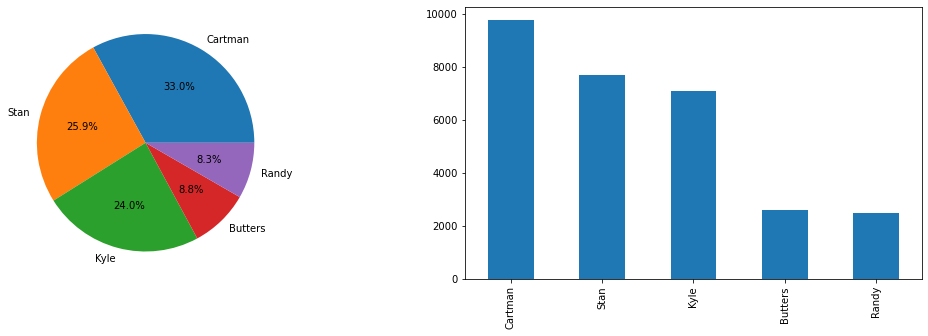

In [9]:
plt.figure(figsize=(15, 6))

ax = plt.subplot(1, 2, 1)
plt.axis("off")
data.Character.value_counts().plot.pie(autopct="%.1f%%", figsize=(5, 5), subplots=True)

ax = plt.subplot(1, 2, 2)
data.Character.value_counts().plot(kind='bar', figsize=(18, 5))

### 2.3. Vérification des données manquantes

In [10]:
data.isna().sum()

Season       0
Episode      0
Character    0
Line         0
dtype: int64

Nous remarquons que nous n'avons aucune donnée manquante

### 2.4. Affichage du contenu de quelques paroles et du personnage associé

In [11]:
# Contenu du premier tweet
data.Line[0], data.Character[0]

('You guys, you guys! Chef is going away. \n', 'Stan')

In [12]:
# Contenu du deuxième tweet
data.Line[1], data.Character[1]

('Going away? For how long?\n', 'Kyle')

In [13]:
# Contenu du troisième tweet
data.Line[2], data.Character[2]

('Forever.\n', 'Stan')

Nous allons supprimer les autres colonnes pour faciliter la lecture de notre dataframe. Nous conservons seulement les colonnes **Line** et **Character**

In [14]:
data = data.drop(["Season", "Episode"], axis=1)

In [15]:
data.head(10)

,Character,Line
0,Stan,"You guys, you guys! Chef is going away. \n"
1,Kyle,Going away? For how long?\n
2,Stan,Forever.\n
4,Stan,"Chef said he's been bored, so he joining a gro..."
9,Cartman,I'm gonna miss him. I'm gonna miss Chef and I...
10,Stan,"Dude, how are we gonna go on? Chef was our fuh..."
17,Randy,"Good-bye, Chef! Have a great time with the Sup..."
19,Kyle,"Draw two card, fatass.\n"
20,Cartman,"Reverse to you, Jew. \n"
21,Stan,I'll get it. \n


# 3. Prétraitement de texte

Pour le prétraitement, nous allons effectuer les tâches suivantes:
- Tockenisation
- Suppression des stopwords
- Lematisation
- Racinisation

In [16]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import EnglishStemmer
import string
import numpy as np

### 3.1.  Tokenisation

Nous allons ici découper les différentes paroles en tockens (mots)

In [17]:
def tokenisation(parole):
    
    if parole is not np.nan:
        try:
            tokens = [word.replace('\n', '').strip() for word in word_tokenize(parole)]
        except:
            pass
        if len(tokens) > 1:
            return tokens
        return None
    else:
        return None

In [18]:
data['tockenized_line'] = data['Line'].apply(tokenisation)

In [19]:
data.head()

,Character,Line,tockenized_line
0,Stan,"You guys, you guys! Chef is going away. \n","[You, guys, ,, you, guys, !, Chef, is, going, ..."
1,Kyle,Going away? For how long?\n,"[Going, away, ?, For, how, long, ?]"
2,Stan,Forever.\n,"[Forever, .]"
4,Stan,"Chef said he's been bored, so he joining a gro...","[Chef, said, he, 's, been, bored, ,, so, he, j..."
9,Cartman,I'm gonna miss him. I'm gonna miss Chef and I...,"[I, 'm, gon, na, miss, him, ., I, 'm, gon, na,..."


### 3.2. Suppression des mots vides (Stopwords)

In [20]:
# Liste des stopwords
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [21]:
# Liste des ponctuations
punctuation = list(string.punctuation) # une liste avec ponctuations
punctuation.append('...')
np.array(punctuation)

array(['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-',
       '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^',
       '_', '`', '{', '|', '}', '~', '...'], dtype='<U3')

In [22]:
def delete_stopwords(parole):
    
    if parole is not None:
        tokens = [word for word in parole if word.lower() not in stopwords.words('english') + punctuation]
        tokens = [token for token in tokens if len(token) > 1]
        if len(tokens) > 1:
            return tokens
        return None

In [23]:
data['line_without_stopword'] = data['tockenized_line'].apply(delete_stopwords)

In [24]:
data.head()

,Character,Line,tockenized_line,line_without_stopword
0,Stan,"You guys, you guys! Chef is going away. \n","[You, guys, ,, you, guys, !, Chef, is, going, ...","[guys, guys, Chef, going, away]"
1,Kyle,Going away? For how long?\n,"[Going, away, ?, For, how, long, ?]","[Going, away, long]"
2,Stan,Forever.\n,"[Forever, .]",None
4,Stan,"Chef said he's been bored, so he joining a gro...","[Chef, said, he, 's, been, bored, ,, so, he, j...","[Chef, said, 's, bored, joining, group, called..."
9,Cartman,I'm gonna miss him. I'm gonna miss Chef and I...,"[I, 'm, gon, na, miss, him, ., I, 'm, gon, na,...","['m, gon, na, miss, 'm, gon, na, miss, Chef, n..."


### 3.3. Lematisation

Nous allons appliquer la lematisation sur le données sur lesquels nous avons enlevé les stopwords

In [25]:
lemmatizer = WordNetLemmatizer()

In [26]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/franel/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [27]:
correspondaces = {'ADJ': "a", 'ADJ_SAT': "s", 'ADV': "r", 'NN': "n", 'VB': "v", "NNS": "n", "NNP": "n", "VBD": "v",
                 "VBN": "v", "VBZ": "v", "VBG": "v"}

In [28]:
def lemmatisation(parole):
    
    if parole is not None:
        #liste_mots = word_tokenize(phrase)
        tokens = [0] * len(parole)
        for ind, mot in enumerate(parole):
            a, b = nltk.pos_tag([mot])[0]

            if b in list(correspondaces.keys()):
                tokens[ind] = lemmatizer.lemmatize(mot, pos=correspondaces[b])
            else:
                tokens[ind] = mot

        tokens = [token for token in tokens if len(token) > 1]

        if len(tokens) > 1:
            return tokens
        return None

In [29]:
data['line_without_stopword_lematisation'] = data['line_without_stopword'].apply(lemmatisation)

In [30]:
data.head()

,Character,Line,tockenized_line,line_without_stopword,line_without_stopword_lematisation
0,Stan,"You guys, you guys! Chef is going away. \n","[You, guys, ,, you, guys, !, Chef, is, going, ...","[guys, guys, Chef, going, away]","[guy, guy, Chef, go, away]"
1,Kyle,Going away? For how long?\n,"[Going, away, ?, For, how, long, ?]","[Going, away, long]","[Going, away, long]"
2,Stan,Forever.\n,"[Forever, .]",None,None
4,Stan,"Chef said he's been bored, so he joining a gro...","[Chef, said, he, 's, been, bored, ,, so, he, j...","[Chef, said, 's, bored, joining, group, called...","[Chef, say, 's, bore, join, group, call, Super..."
9,Cartman,I'm gonna miss him. I'm gonna miss Chef and I...,"[I, 'm, gon, na, miss, him, ., I, 'm, gon, na,...","['m, gon, na, miss, 'm, gon, na, miss, Chef, n...","['m, gon, na, miss, 'm, gon, na, miss, Chef, n..."


In [31]:
# On vérifie qu'il nya pas de documents vides
data['line_without_stopword_lematisation'].isnull().sum()

4591

In [32]:
# On supprime tous les documents vides
data.dropna(subset=['line_without_stopword_lematisation'], inplace=True)

In [33]:
# On vérifie qu'il nya pas de documents vides
data['line_without_stopword_lematisation'].isnull().sum()

0

### 3.4. Racinisation

Nous allons appliquer la racinisation sur le données sur lesquels nous avons enlevé les stopwords

In [34]:
stemmer = EnglishStemmer()

In [35]:
def stemming(parole):
    
    if parole is not None:
        tokens = [stemmer.stem(word) for word in parole]
        tokens = [token for token in tokens if len(token) > 1]

        if len(tokens) > 1:
            return tokens
        return None

In [36]:
data['line_without_stopword_stemming'] = data['line_without_stopword'].apply(stemming)

In [37]:
data.head()

,Character,Line,tockenized_line,line_without_stopword,line_without_stopword_lematisation,line_without_stopword_stemming
0,Stan,"You guys, you guys! Chef is going away. \n","[You, guys, ,, you, guys, !, Chef, is, going, ...","[guys, guys, Chef, going, away]","[guy, guy, Chef, go, away]","[guy, guy, chef, go, away]"
1,Kyle,Going away? For how long?\n,"[Going, away, ?, For, how, long, ?]","[Going, away, long]","[Going, away, long]","[go, away, long]"
4,Stan,"Chef said he's been bored, so he joining a gro...","[Chef, said, he, 's, been, bored, ,, so, he, j...","[Chef, said, 's, bored, joining, group, called...","[Chef, say, 's, bore, join, group, call, Super...","[chef, said, 's, bore, join, group, call, supe..."
9,Cartman,I'm gonna miss him. I'm gonna miss Chef and I...,"[I, 'm, gon, na, miss, him, ., I, 'm, gon, na,...","['m, gon, na, miss, 'm, gon, na, miss, Chef, n...","['m, gon, na, miss, 'm, gon, na, miss, Chef, n...","['m, gon, na, miss, 'm, gon, na, miss, chef, n..."
10,Stan,"Dude, how are we gonna go on? Chef was our fuh...","[Dude, ,, how, are, we, gon, na, go, on, ?, Ch...","[Dude, gon, na, go, Chef, fuh, f-ffriend]","[Dude, gon, na, go, Chef, fuh, f-ffriend]","[dude, gon, na, go, chef, fuh, f-ffriend]"


In [38]:
# On vérifie qu'il nya pas de documents vides
data['line_without_stopword_stemming'].isnull().sum()

0

### 3.5. Fréquence des mots par personnage

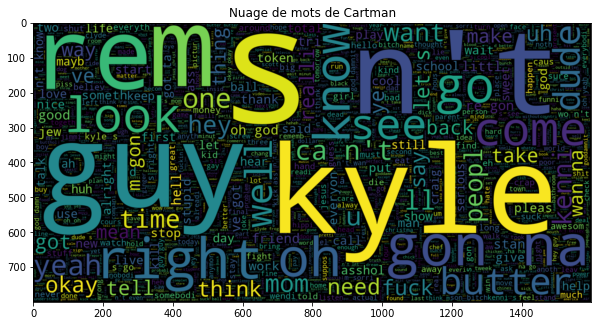

In [47]:
# Cartman

from wordcloud import WordCloud
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 10000 , width = 1600 , height = 800).generate(" ".join([" ".join(word) for word in data[data.Character == 'Cartman'].line_without_stopword_stemming]))
plt.imshow(wc , interpolation='bilinear')
plt.title('Nuage de mots de Cartman')
plt.show()

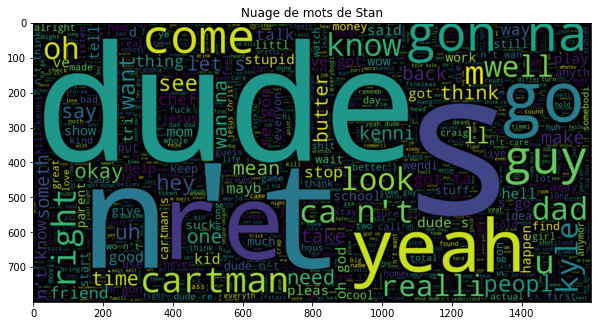

In [48]:
# Stan 

from wordcloud import WordCloud
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 10000 , width = 1600 , height = 800).generate(" ".join([" ".join(word) for word in data[data.Character == 'Stan'].line_without_stopword_stemming]))
plt.title('Nuage de mots de Stan')
plt.imshow(wc , interpolation='bilinear')
plt.show()

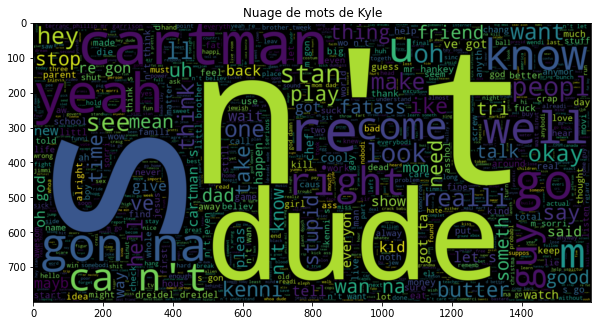

In [49]:
# Kyle

from wordcloud import WordCloud
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 10000 , width = 1600 , height = 800).generate(" ".join([" ".join(word) for word in data[data.Character == 'Kyle'].line_without_stopword_stemming]))
plt.imshow(wc , interpolation='bilinear')
plt.title('Nuage de mots de Kyle')
plt.show()

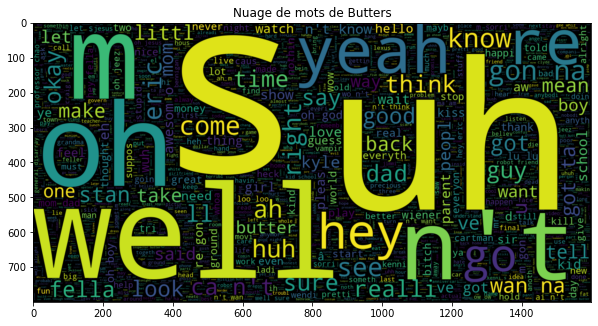

In [50]:
# Butters 

from wordcloud import WordCloud
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 10000 , width = 1600 , height = 800).generate(" ".join([" ".join(word) for word in data[data.Character == 'Butters'].line_without_stopword_stemming]))
plt.imshow(wc , interpolation='bilinear')
plt.title('Nuage de mots de Butters')
plt.show()

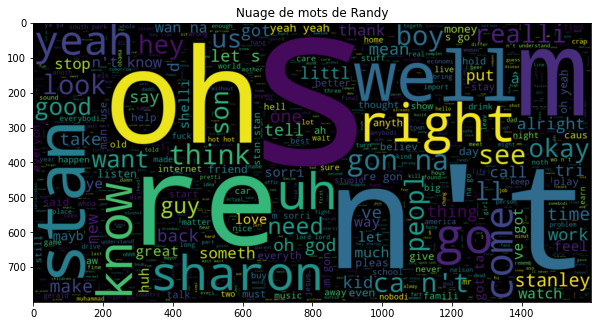

In [51]:
# Randy

from wordcloud import WordCloud
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 10000 , width = 1600 , height = 800).generate(" ".join([" ".join(word) for word in data[data.Character == 'Randy'].line_without_stopword_stemming]))
plt.imshow(wc , interpolation='bilinear')
plt.title('Nuage de mots de Randy')
plt.show()

# 3. Découpage des données

Nous effectuons le découpage des données afin de les utiliser pour la formation et le test des modèles de machine learning.

Nous allons utiliser les données issues de la lematisation et ceux issues de la racinisation pour chaque modèle que nous allons utiliser.

In [39]:
from sklearn.model_selection import train_test_split

Nous allons diviser les données de la manière suivante:
- 30 % pour le test
- 70 % pour le train

In [40]:
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split([ ' '.join(t) for t in data['line_without_stopword_lematisation']], data['Character'], test_size=0.3)
X_train_rac, X_test_rac, y_train_rac, y_test_rac = train_test_split([ ' '.join(t) for t in data['line_without_stopword_stemming']], data['Character'], test_size=0.3)

print(len(X_train_lem), len(X_test_lem))
print(len(X_train_rac), len(X_test_rac))

17521 7510
17521 7510


# 4. Machine learning

Nous allons utiliser les modèles suivants :

- MultinomialNB (NaiveBayes)
- LinearSVC (SVM)
- LogisticRegression
- RandomForestClassifier
- DecisionTreeClassifier

Après avois formé les différents modèles, nous allons les comparer et faire des commentaires

In [41]:
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

### 4.1. MultinomialNB (NaiveBayes)

Nous allons utiliser les données issues de la lematinsation et ceux issues de la racinisation

In [42]:
# Création des modèles (Vectorisation, TFIDF, MultinomialNB)
NB_clf_lem = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())])

NB_clf_rac = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())])

In [43]:
# Entrainement des modèles
NB_clf_lem.fit(X_train_lem, y_train_lem)
NB_clf_rac.fit(X_train_rac, y_train_rac)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [44]:
# Résultats sur les données issues de la lematisation
y_pred_lem = NB_clf_lem.predict(X_test_lem)
print(classification_report(y_test_lem, y_pred_lem))

              precision    recall  f1-score   support

     Butters       0.88      0.07      0.13       674
     Cartman       0.44      0.85      0.58      2639
        Kyle       0.49      0.22      0.30      1714
       Randy       0.97      0.04      0.08       653
        Stan       0.41      0.34      0.37      1830

    accuracy                           0.44      7510
   macro avg       0.63      0.30      0.29      7510
weighted avg       0.53      0.44      0.38      7510



In [45]:
# Résultats sur les données issues de la racinisation
y_pred_rac = NB_clf_rac.predict(X_test_rac)
print(classification_report(y_test_rac, y_pred_rac))

              precision    recall  f1-score   support

     Butters       0.90      0.08      0.14       688
     Cartman       0.41      0.88      0.56      2517
        Kyle       0.54      0.20      0.29      1771
       Randy       0.88      0.04      0.08       641
        Stan       0.43      0.32      0.37      1893

    accuracy                           0.43      7510
   macro avg       0.63      0.30      0.29      7510
weighted avg       0.53      0.43      0.37      7510



Text(587.5454545454544, 0.5, 'Classes prédites')

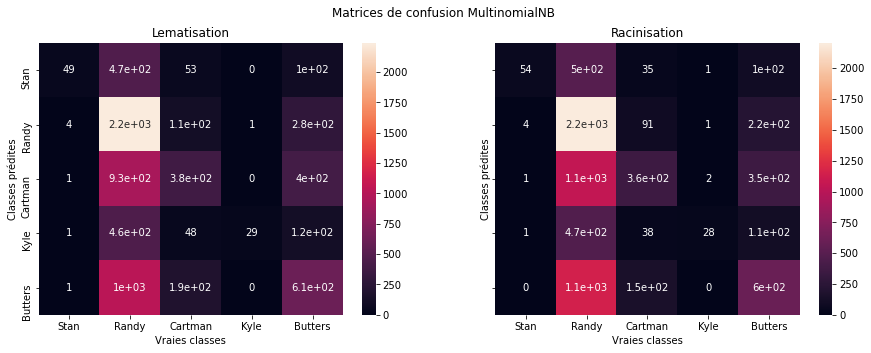

In [46]:
# Matrice de confusion
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Matrices de confusion MultinomialNB')

# Bulbasaur
sns.heatmap(confusion_matrix(y_test_lem, y_pred_lem), annot=True, xticklabels=set(data['Character']), yticklabels=set(data['Character']), ax=axes[0])
axes[0].set_title('Lematisation')
axes[0].set_xlabel('Vraies classes')
axes[0].set_ylabel('Classes prédites')

# Charmander
sns.heatmap(confusion_matrix(y_test_rac, y_pred_rac), annot=True, xticklabels=set(data['Character']), yticklabels=set(data['Character']), ax=axes[1])
axes[1].set_title('Racinisation')
axes[1].set_xlabel('Vraies classes')
axes[1].set_ylabel('Classes prédites')

Nous constatons que avec la lematisation, nous avons un socre F1 de 44% alors que avec la racinisation, nous avons un score F1 ed 43%

Nous remarquons également que les paroles de Randy sont très mals classées par rapport aux autres personnages

### 4.2. LinearSVC (SVM)

Nous allons utiliser les données issues de la lematinsation et ceux issues de la racinisation

In [47]:
# Création des modèles (Vectorisation, TFIDF, MultinomialNB)
SVM_clf_lem = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', svm.LinearSVC())])

SVM_clf_rac = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', svm.LinearSVC())])

In [48]:
# Entrainement des modèles
SVM_clf_lem.fit(X_train_lem, y_train_lem)
SVM_clf_rac.fit(X_train_rac, y_train_rac)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LinearSVC())])

In [49]:
# Résultats sur les données issues de la lematisation
y_pred_lem = SVM_clf_lem.predict(X_test_lem)
print(classification_report(y_test_lem, y_pred_lem))

              precision    recall  f1-score   support

     Butters       0.52      0.36      0.43       674
     Cartman       0.55      0.63      0.59      2639
        Kyle       0.41      0.39      0.40      1714
       Randy       0.51      0.32      0.39       653
        Stan       0.40      0.44      0.42      1830

    accuracy                           0.48      7510
   macro avg       0.48      0.43      0.45      7510
weighted avg       0.48      0.48      0.47      7510



In [50]:
# Résultats sur les données issues de la racinisation
y_pred_rac = SVM_clf_rac.predict(X_test_rac)
print(classification_report(y_test_rac, y_pred_rac))

              precision    recall  f1-score   support

     Butters       0.55      0.35      0.43       688
     Cartman       0.52      0.67      0.59      2517
        Kyle       0.43      0.36      0.39      1771
       Randy       0.53      0.32      0.40       641
        Stan       0.41      0.43      0.42      1893

    accuracy                           0.48      7510
   macro avg       0.49      0.43      0.45      7510
weighted avg       0.48      0.48      0.47      7510



Text(587.5454545454544, 0.5, 'Classes prédites')

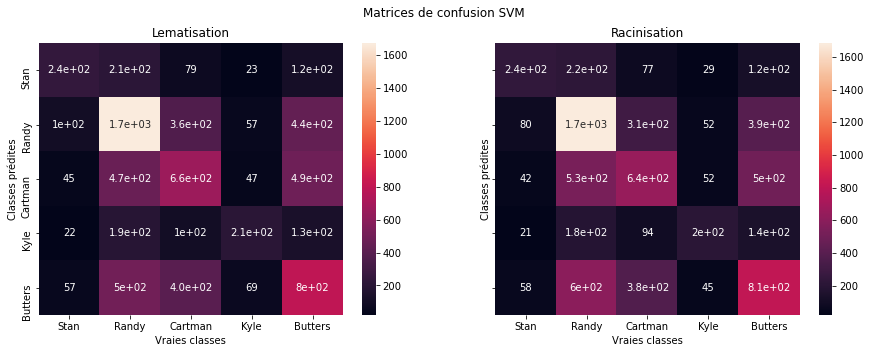

In [51]:
# Matrice de confusion
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Matrices de confusion SVM')

# Bulbasaur
sns.heatmap(confusion_matrix(y_test_lem, y_pred_lem), annot=True, xticklabels=set(data['Character']), yticklabels=set(data['Character']), ax=axes[0])
axes[0].set_title('Lematisation')
axes[0].set_xlabel('Vraies classes')
axes[0].set_ylabel('Classes prédites')

# Charmander
sns.heatmap(confusion_matrix(y_test_rac, y_pred_rac), annot=True, xticklabels=set(data['Character']), yticklabels=set(data['Character']), ax=axes[1])
axes[1].set_title('Racinisation')
axes[1].set_xlabel('Vraies classes')
axes[1].set_ylabel('Classes prédites')

Nous constatons que avec la lematisation et la racinisation, nous obtenons le score F1 de 48%

Toutes les classes sont moyennement bien classées

### 4.3. LogisticRegression

Nous allons utiliser les données issues de la lematinsation et ceux issues de la racinisation

In [52]:
# Création des modèles (Vectorisation, TFIDF, MultinomialNB)
LR_clf_lem = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression())])

LR_clf_rac = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression())])

In [53]:
# Entrainement des modèles
LR_clf_lem.fit(X_train_lem, y_train_lem)
LR_clf_rac.fit(X_train_rac, y_train_rac)

/home/franel/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/franel/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression())])

In [54]:
# Résultats sur les données issues de la lematisation
y_pred_lem = LR_clf_lem.predict(X_test_lem)
print(classification_report(y_test_lem, y_pred_lem))

              precision    recall  f1-score   support

     Butters       0.59      0.28      0.38       674
     Cartman       0.52      0.73      0.61      2639
        Kyle       0.42      0.35      0.38      1714
       Randy       0.68      0.24      0.35       653
        Stan       0.41      0.41      0.41      1830

    accuracy                           0.48      7510
   macro avg       0.52      0.40      0.43      7510
weighted avg       0.49      0.48      0.47      7510



In [55]:
# Résultats sur les données issues de la racinisation
y_pred_rac = LR_clf_rac.predict(X_test_rac)
print(classification_report(y_test_rac, y_pred_rac))

              precision    recall  f1-score   support

     Butters       0.60      0.27      0.37       688
     Cartman       0.49      0.76      0.60      2517
        Kyle       0.46      0.32      0.38      1771
       Randy       0.63      0.21      0.31       641
        Stan       0.41      0.41      0.41      1893

    accuracy                           0.48      7510
   macro avg       0.52      0.39      0.41      7510
weighted avg       0.49      0.48      0.45      7510



Text(587.5454545454544, 0.5, 'Classes prédites')

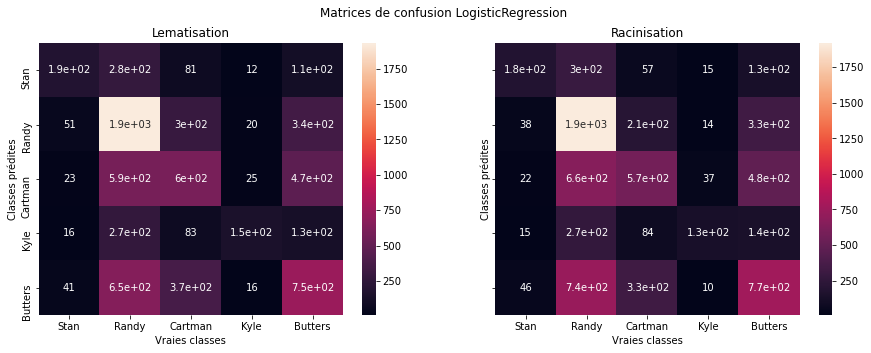

In [56]:
# Matrice de confusion
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Matrices de confusion LogisticRegression')

# Bulbasaur
sns.heatmap(confusion_matrix(y_test_lem, y_pred_lem), annot=True, xticklabels=set(data['Character']), yticklabels=set(data['Character']), ax=axes[0])
axes[0].set_title('Lematisation')
axes[0].set_xlabel('Vraies classes')
axes[0].set_ylabel('Classes prédites')

# Charmander
sns.heatmap(confusion_matrix(y_test_rac, y_pred_rac), annot=True, xticklabels=set(data['Character']), yticklabels=set(data['Character']), ax=axes[1])
axes[1].set_title('Racinisation')
axes[1].set_xlabel('Vraies classes')
axes[1].set_ylabel('Classes prédites')

Nous constatons que avec la racinisation et la lematisation, nous avons un score F1 de 48%

Toutes les classes sont moyennement bien classées, mis à part les paroles de Butters

### 4.4. RandomForestClassifier

Nous allons utiliser les données issues de la lematinsation et ceux issues de la racinisation

In [57]:
# Création des modèles (Vectorisation, TFIDF, MultinomialNB)
RF_clf_lem = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier())])

RF_clf_rac = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier())])

In [58]:
# Entrainement des modèles
RF_clf_lem.fit(X_train_lem, y_train_lem)
RF_clf_rac.fit(X_train_rac, y_train_rac)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier())])

In [59]:
# Résultats sur les données issues de la lematisation
y_pred_lem = RF_clf_lem.predict(X_test_lem)
print(classification_report(y_test_lem, y_pred_lem))

              precision    recall  f1-score   support

     Butters       0.58      0.28      0.38       674
     Cartman       0.52      0.70      0.59      2639
        Kyle       0.40      0.32      0.36      1714
       Randy       0.57      0.21      0.30       653
        Stan       0.38      0.41      0.40      1830

    accuracy                           0.46      7510
   macro avg       0.49      0.38      0.40      7510
weighted avg       0.47      0.46      0.45      7510



In [60]:
# Résultats sur les données issues de la racinisation
y_pred_rac = RF_clf_rac.predict(X_test_rac)
print(classification_report(y_test_rac, y_pred_rac))

              precision    recall  f1-score   support

     Butters       0.52      0.27      0.36       688
     Cartman       0.49      0.71      0.58      2517
        Kyle       0.44      0.34      0.39      1771
       Randy       0.53      0.20      0.29       641
        Stan       0.41      0.40      0.40      1893

    accuracy                           0.46      7510
   macro avg       0.48      0.38      0.40      7510
weighted avg       0.46      0.46      0.44      7510



Text(587.5454545454544, 0.5, 'Classes prédites')

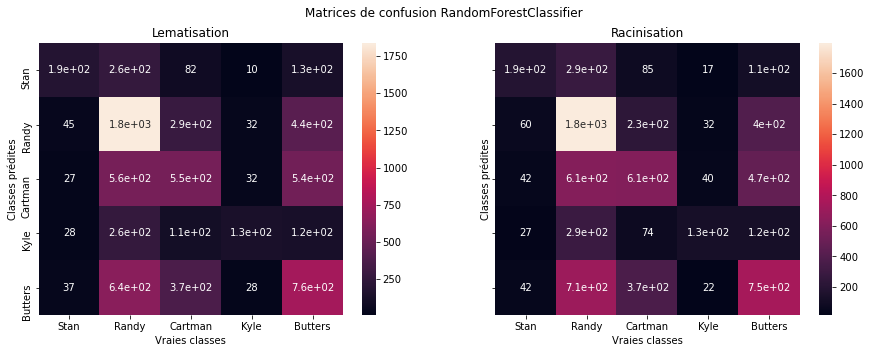

In [61]:
# Matrice de confusion
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Matrices de confusion RandomForestClassifier')

# Bulbasaur
sns.heatmap(confusion_matrix(y_test_lem, y_pred_lem), annot=True, xticklabels=set(data['Character']), yticklabels=set(data['Character']), ax=axes[0])
axes[0].set_title('Lematisation')
axes[0].set_xlabel('Vraies classes')
axes[0].set_ylabel('Classes prédites')

# Charmander
sns.heatmap(confusion_matrix(y_test_rac, y_pred_rac), annot=True, xticklabels=set(data['Character']), yticklabels=set(data['Character']), ax=axes[1])
axes[1].set_title('Racinisation')
axes[1].set_xlabel('Vraies classes')
axes[1].set_ylabel('Classes prédites')

Nous constatons que nous obtenons les mêmes score F1 de 46%.

Toutes les classes sont faiblement bien classées

### 4.5. DecisionTreeClassifier

Nous allons utiliser les données issues de la lematinsation et ceux issues de la racinisation

In [62]:
# Création des modèles (Vectorisation, TFIDF, MultinomialNB)
DT_clf_lem = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', DecisionTreeClassifier())])

DT_clf_rac = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', DecisionTreeClassifier())])

In [63]:
# Entrainement des modèles
DT_clf_lem.fit(X_train_lem, y_train_lem)
DT_clf_rac.fit(X_train_rac, y_train_rac)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', DecisionTreeClassifier())])

In [64]:
# Résultats sur les données issues de la lematisation
y_pred_lem = DT_clf_lem.predict(X_test_lem)
print(classification_report(y_test_lem, y_pred_lem))

              precision    recall  f1-score   support

     Butters       0.34      0.27      0.30       674
     Cartman       0.52      0.53      0.52      2639
        Kyle       0.36      0.35      0.35      1714
       Randy       0.32      0.24      0.27       653
        Stan       0.36      0.41      0.38      1830

    accuracy                           0.41      7510
   macro avg       0.38      0.36      0.37      7510
weighted avg       0.41      0.41      0.41      7510



In [65]:
# Résultats sur les données issues de la racinisation
y_pred_rac = DT_clf_rac.predict(X_test_rac)
print(classification_report(y_test_rac, y_pred_rac))

              precision    recall  f1-score   support

     Butters       0.34      0.26      0.30       688
     Cartman       0.47      0.54      0.50      2517
        Kyle       0.37      0.34      0.35      1771
       Randy       0.33      0.23      0.27       641
        Stan       0.35      0.37      0.36      1893

    accuracy                           0.40      7510
   macro avg       0.37      0.35      0.36      7510
weighted avg       0.39      0.40      0.39      7510



Text(587.5454545454544, 0.5, 'Classes prédites')

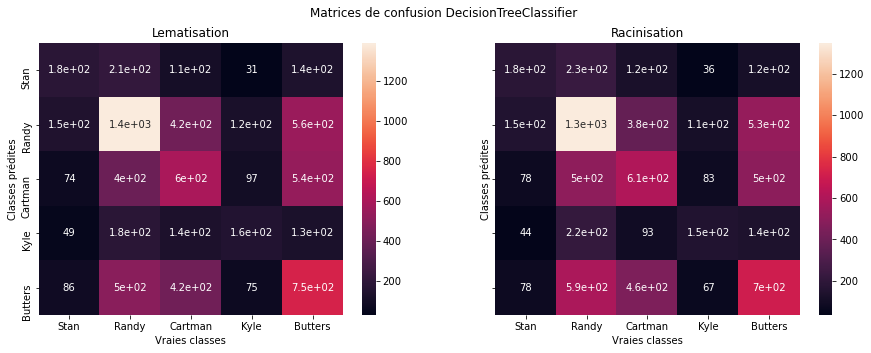

In [66]:
# Matrice de confusion
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Matrices de confusion DecisionTreeClassifier')

# Bulbasaur
sns.heatmap(confusion_matrix(y_test_lem, y_pred_lem), annot=True, xticklabels=set(data['Character']), yticklabels=set(data['Character']), ax=axes[0])
axes[0].set_title('Lematisation')
axes[0].set_xlabel('Vraies classes')
axes[0].set_ylabel('Classes prédites')

# Charmander
sns.heatmap(confusion_matrix(y_test_rac, y_pred_rac), annot=True, xticklabels=set(data['Character']), yticklabels=set(data['Character']), ax=axes[1])
axes[1].set_title('Racinisation')
axes[1].set_xlabel('Vraies classes')
axes[1].set_ylabel('Classes prédites')

Nous constatons que avec la racinisation, nous obtenons un meilleur score F1 de 41% alors que avec la lematisation, nous abtenons seulement 40%.

Toutes les classes sont faiblement bien classées

### 4.6. Analyse des résultats

Après l'entrainement et le test de tous les modèles, nous obtenons les résultats suivants:

----------------------------------------------------
- MultinomialNB (NaiveBayes) : 
    - Lematisation : 44%
    - Racinisation : 43%
- LinearSVC (SVM) : 
    - Lematisation : 48%
    - Racinisation : 48%
- LogisticRegression :
    - Lematisation : 48%
    - Racinisation : 48%
- RandomForestClassifier :
    - Lematisation : 46%
    - Racinisation : 46%
- DecisionTreeClassifier :
    - Lematisation : 41%
    - Racinisation : 40%
----------------------------------------------------

Nous pouvons donc conclure que nous avons de meilleurs résultats avec les models LogisticRegression et SVM (48%). 

Nous remarquons que pour tous les classifieurs, la lematisation et la racinisation donnent quasiment toujours les mêmes résultats.

Dans l'ensemble, les résultas de classification sont médiocres pour l'ensemble des classifieurs

# 5. Neural network

In [67]:
import ast
import os
from tensorflow.keras.layers import Dense, Embedding, Input
from tensorflow.keras.layers import Dropout, Flatten, GlobalMaxPooling1D, Bidirectional, LSTM
from tensorflow.keras.models import Model
import numpy as np
import itertools
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import (classification_report, 
                             precision_recall_fscore_support, 
                             accuracy_score)

from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.layers import Concatenate

import tensorflow as tf

In [68]:
MAX_FEATURES = 10000
VOCAB_SIZE = 1024
EMBEDDING_SIZE  = 300
BATCH_SIZE = 64
EPOCHS = 5
VALIDATION_SPLIT = 0.2

In [69]:
# Création des données textuelles dans le format correct pour le réseau neuronal
def get_train_test(train_raw_text, test_raw_text):
    
    tokenizer = text.Tokenizer(num_words=MAX_FEATURES)

    tokenizer.fit_on_texts(list(train_raw_text))
    
    train_tokenized = tokenizer.texts_to_sequences(train_raw_text)
    test_tokenized = tokenizer.texts_to_sequences(test_raw_text)
    
    return sequence.pad_sequences(train_tokenized, maxlen=VOCAB_SIZE), \
           sequence.pad_sequences(test_tokenized, maxlen=VOCAB_SIZE)

In [70]:
x_vec_train, x_vec_test = get_train_test(X_train_lem, X_test_lem)
len(x_vec_train), len(x_vec_test)

(17521, 7510)

In [71]:
# Liste des différentes classes
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
CLASSES_LIST = np.unique(data['Character'])
n_out = len(CLASSES_LIST)
print(CLASSES_LIST, n_out)
le.fit(CLASSES_LIST)

y_train_encoded = le.transform(y_train_lem) 
y_test_encoded = le.transform(y_test_lem) 
train_y_cat = to_categorical(y_train_encoded, n_out)
print(y_train_encoded[:5])

['Butters' 'Cartman' 'Kyle' 'Randy' 'Stan'] 5
[0 1 0 1 4]


In [72]:
# OneHot Encoding sur les labels
train_y_cat = to_categorical(y_train_encoded, n_out)
train_y_cat

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [73]:
# Création du modèle
def get_model():

    inputs = Input(shape=(VOCAB_SIZE,))
    model = Embedding(MAX_FEATURES, EMBEDDING_SIZE)(inputs)
    dropout_1 = Dropout(0.5)(model)
    bidirectional_1 = Bidirectional(LSTM(64,  return_sequences=True))(dropout_1)
    bidirectional_2 = Bidirectional(LSTM(32))(bidirectional_1)
    
    model = Dense(128, activation='relu')(bidirectional_2)
    model = Dense(64, activation='relu')(model)
    dropout_2 = Dropout(0.5)(model)

    outputs = Dense(n_out, activation="softmax")(dropout_2)
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [74]:
model = get_model()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1024)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1024, 300)         3000000   
_________________________________________________________________
dropout (Dropout)            (None, 1024, 300)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 1024, 128)         186880    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256  

In [75]:
# Entrainement du modèle
def train_fit_predict(model, X_train, X_test, y):
    
    history = model.fit(X_train, y,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS, verbose=1,
              validation_split=VALIDATION_SPLIT)

    return model.predict(X_test), history

In [76]:
# Entrainement et prédiction
y_predicted, history = train_fit_predict(model, x_vec_train, x_vec_test, train_y_cat)

Epoch 1/5
219/219 [==============================] - 1197s 5s/step - loss: 1.5021 - accuracy: 0.3121 - val_loss: 1.3599 - val_accuracy: 0.3835
Epoch 2/5
219/219 [==============================] - 1257s 6s/step - loss: 1.2602 - accuracy: 0.4449 - val_loss: 1.3239 - val_accuracy: 0.4143
Epoch 3/5
219/219 [==============================] - 1198s 5s/step - loss: 1.1105 - accuracy: 0.5113 - val_loss: 1.3800 - val_accuracy: 0.4171
Epoch 4/5
219/219 [==============================] - 1177s 5s/step - loss: 1.0019 - accuracy: 0.5559 - val_loss: 1.3632 - val_accuracy: 0.4328
Epoch 5/5
219/219 [==============================] - 1166s 5s/step - loss: 0.8967 - accuracy: 0.6095 - val_loss: 1.4521 - val_accuracy: 0.4417


In [77]:
y_predicted = y_predicted.argmax(1)

In [78]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

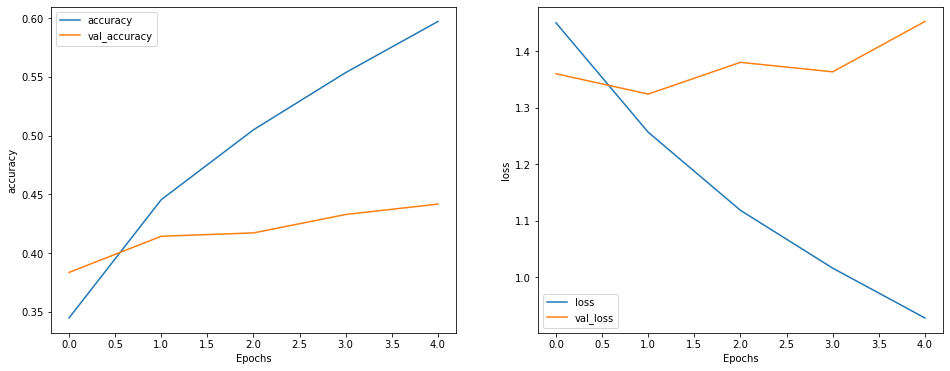

In [79]:
# Courbe d'apprentissage
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

In [80]:
# Résultat obtenus
print(classification_report(y_test_encoded, y_predicted, target_names=CLASSES_LIST))

              precision    recall  f1-score   support

     Butters       0.42      0.32      0.36       674
     Cartman       0.53      0.63      0.58      2639
        Kyle       0.42      0.27      0.33      1714
       Randy       0.40      0.29      0.34       653
        Stan       0.34      0.43      0.38      1830

    accuracy                           0.44      7510
   macro avg       0.42      0.39      0.40      7510
weighted avg       0.44      0.44      0.43      7510



# Conclusion

Nous avons remarqué qu'en utilisant les réseaux de neurones, notre score F1 est faible. Cependant, étant donné la courbe d'apprentissage, nous pensons qu'au fur et à mesure que les temps se développent, de meilleurs scores F1 peuvent être obtenus.